In [ ]:
import os
os.chdir('/content/drive/MyDrive/Deep learning/iris_detection_scratch')

In [ ]:
!pip install tensorflow-gpu opencv-python matplotlib

     |████████████████████████████████| 497.5 MB 24 kB/s 
     |████████████████████████████████| 462 kB 44.6 MB/s 


In [1]:
import cv2
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# for setting memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
def load_image(x):
  byte_img=tf.io.read_file(x)
  img=tf.io.decode_jpeg(byte_img)
  return img

In [ ]:
len(os.listdir('aug_data/images')),len(os.listdir('aug_data/labels'))

(2600, 2600)

In [ ]:
images=tf.data.Dataset.list_files('aug_data/images/*.jpg', shuffle=False)

In [ ]:
train_images=images.take(2100)
train_images=train_images.map(load_image)
train_images=train_images.map(lambda x : tf.image.resize(x,(250,250)))
train_images=train_images.map(lambda x:x/255.0)

In [ ]:
test_images=images.skip(2100)
test_images=test_images.take(500)
test_images=test_images.map(load_image)
test_images=test_images.map(lambda x : tf.image.resize(x,(250,250)))
test_images=test_images.map(lambda x:x/255.0)

In [ ]:
def load_label(x):
  with open(x.numpy(), 'r', encoding='utf-8') as f:
    label=json.load(f)
    return [label['keypoints']]

In [ ]:
labels=tf.data.Dataset.list_files('aug_data/labels/*.json',shuffle=False)

In [ ]:
train_labels=labels.take(2100)
train_labels=train_labels.map(lambda x : tf.py_function(load_label,[x],[tf.float16]))

In [ ]:
itert=train_labels.as_numpy_iterator()

In [ ]:
itert.next()

(array([0.5854, 0.3818, 0.3818, 0.3567], dtype=float16),)

In [ ]:
test_labels=labels.skip(2100)
test_labels=test_labels.take(500)
test_labels=test_labels.map(lambda x:tf.py_function(load_label, [x], [tf.float16]))

In [ ]:
itert1=train_labels.as_numpy_iterator()

In [ ]:
itert1.next()

(array([0.5854, 0.3818, 0.3818, 0.3567], dtype=float16),)

In [ ]:
train=tf.data.Dataset.zip((train_images,train_labels))
train=train.shuffle(3000)
train=train.batch(8)
train=train.prefetch(4)

In [ ]:
test=tf.data.Dataset.zip((test_images,test_labels))
test=test.shuffle(3000)
test=test.batch(8)
test=test.prefetch(4)

In [ ]:
q=test.as_numpy_iterator()

In [ ]:
tes=q.next()

In [ ]:
tes[1]

(array([[0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.693 , 0.584 , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.682 , 0.3916, 0.    , 0.    ]], dtype=float16),)

In [ ]:
t=train.as_numpy_iterator()

In [ ]:
res=t.next()

In [ ]:
res[1]

(array([[0.3215, 0.501 , 0.532 , 0.4944],
        [0.    , 0.    , 0.    , 0.    ],
        [0.3967, 0.4604, 0.5835, 0.467 ],
        [0.5967, 0.5586, 0.423 , 0.5503],
        [0.5244, 0.5107, 0.339 , 0.5073],
        [0.562 , 0.4429, 0.355 , 0.4495],
        [0.5317, 0.388 , 0.345 , 0.4082],
        [0.335 , 0.548 , 0.5454, 0.541 ]], dtype=float16),)

In [ ]:
res[0].shape

(8, 250, 250, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


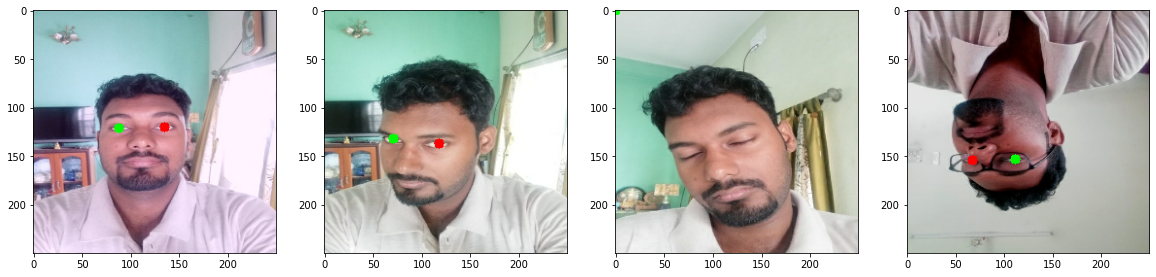

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 5, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 5, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout,Flatten,Dense
from tensorflow.keras.applications import ResNet152V2

In [ ]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Flatten(),
    Dense(100,activation='relu'),
    Dense(4,activation='sigmoid')
])

In [ ]:
pred=model.predict(res[0])
pred

array([[0.29998264, 0.55639714, 0.32551053, 0.20184024],
       [0.3428845 , 0.5173123 , 0.3234331 , 0.22988166],
       [0.32359278, 0.6242927 , 0.35355464, 0.2786727 ],
       [0.29378393, 0.6173816 , 0.370301  , 0.2560098 ],
       [0.20661654, 0.66097444, 0.21705446, 0.2533375 ],
       [0.39092326, 0.57772434, 0.4117367 , 0.2964775 ],
       [0.2121667 , 0.85465884, 0.39788395, 0.5685458 ],
       [0.3021203 , 0.5002595 , 0.2851709 , 0.24836172]], dtype=float32)

In [ ]:
res[1]

(array([[0.3367, 0.4375, 0.5405, 0.412 ],
        [0.6055, 0.552 , 0.4321, 0.5435],
        [0.589 , 0.5684, 0.3816, 0.5615],
        [0.5303, 0.4568, 0.7173, 0.477 ],
        [0.5947, 0.547 , 0.    , 0.    ],
        [0.6396, 0.579 , 0.436 , 0.577 ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.5146, 0.621 , 0.7017, 0.6006]], dtype=float16),)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 256)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 1, 4)          

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [ ]:
loss(res[1],pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.08506105>

In [ ]:
model.compile(optimizer, loss)

In [ ]:
hist=model.fit(test,epochs=30)

Epoch 1/30
63/63 [==============================] - 26s 339ms/step - loss: 0.0018
Epoch 2/30
63/63 [==============================] - 24s 338ms/step - loss: 0.0021
Epoch 3/30
63/63 [==============================] - 24s 332ms/step - loss: 6.1273e-04
Epoch 4/30
63/63 [==============================] - 24s 333ms/step - loss: 4.9618e-04
Epoch 5/30
63/63 [==============================] - 24s 337ms/step - loss: 2.7492e-04
Epoch 6/30
63/63 [==============================] - 24s 337ms/step - loss: 1.5798e-04
Epoch 7/30
63/63 [==============================] - 24s 336ms/step - loss: 1.2987e-04
Epoch 8/30
63/63 [==============================] - 24s 338ms/step - loss: 1.1806e-04
Epoch 9/30
63/63 [==============================] - 24s 333ms/step - loss: 9.1937e-05
Epoch 10/30
63/63 [==============================] - 24s 334ms/step - loss: 7.9714e-05
Epoch 11/30
63/63 [==============================] - 24s 340ms/step - loss: 5.7811e-05
Epoch 12/30
63/63 [==============================] - 24s 333

KeyboardInterrupt: ignored

In [ ]:
model.save('iris_detection_updated.pb')

INFO:tensorflow:Assets written to: iris_detection_updated.pb/assets


In [2]:
model1=tf.keras.models.load_model('iris_detection_updated.pb')

In [ ]:
pred2=model1.predict(res[0])
pred2

array([[3.1144851e-01, 5.0853413e-01, 5.1808083e-01, 4.9347192e-01],
       [1.7081768e-05, 8.3372877e-05, 6.7796710e-12, 4.1048165e-11],
       [4.0218687e-01, 4.7116825e-01, 5.8219445e-01, 4.6997479e-01],
       [6.1039960e-01, 5.5123430e-01, 4.2727777e-01, 5.4960400e-01],
       [5.2885747e-01, 5.0332129e-01, 3.3374178e-01, 5.0629944e-01],
       [5.7760829e-01, 4.5097473e-01, 3.7095770e-01, 4.4910577e-01],
       [5.2229273e-01, 3.9716607e-01, 3.4147826e-01, 4.1253826e-01],
       [3.2790747e-01, 5.4396683e-01, 5.3744769e-01, 5.4041338e-01]],
      dtype=float32)

# Vizualise the prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.3114485  0.50853413 0.51808083 0.49347192]
[1.7081768e-05 8.3372877e-05 6.7796710e-12 4.1048165e-11]
[0.40218687 0.47116825 0.58219445 0.4699748 ]
[0.6103996  0.5512343  0.42727777 0.549604  ]


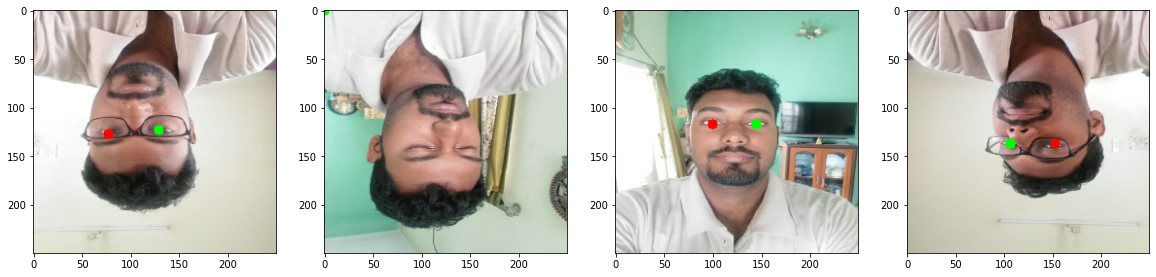

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = pred2[idx]
    print(sample_coords)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 5, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 5, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)